## Exercise 06 : Scatter Matrix

In [67]:
import pandas as pd
from pandas.plotting import scatter_matrix
import sqlite3

In [68]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

In [69]:
query = """
        select uid, count(*) as pageviews from pageviews
        where uid like 'user_%'
        group by uid
        """

views = pd.read_sql(query, conn)
views

,uid,pageviews
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


In [70]:
query = """
        select uid, count(*) as num_commits from checker
        where uid like 'user_%' and labname != 'project1'
        group by uid
        """

commits = pd.read_sql(query, conn)
commits

,uid,num_commits
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86
5,user_13,52
6,user_14,61
7,user_15,23
8,user_16,41
9,user_17,51


In [71]:
query = """
        create table if not exists test as
        select checker.uid,
               checker.labname,
               checker.timestamp  as first_commit_ts,
               pageviews.datetime as first_view_ts
        from checker
                left join pageviews on checker.uid = pageviews.uid
        where checker.uid like 'user_%'
          and numTrials = 1
          and status = 'ready'
          and labname in ('laba04', 'laba04s', 'laba05', 'laba06', 'laba06s', 'project1')
          and pageviews.datetime = (select min(pageviews.datetime) from pageviews
                                    where uid = checker.uid);
        """

conn.execute(query)

In [72]:
query = """
        select uid, cast((julianday(test.first_commit_ts) - julianday(datetime(deadlines.deadlines, 'unixepoch')))
                * 24 as integer) as avg_diff
        from test
        left join deadlines on deadlines.labs = labname
        where labname != 'project1';
        """

delta = pd.read_sql(query, conn)
delta

,uid,avg_diff
0,user_30,-202
1,user_30,-201
2,user_14,-200
3,user_14,-193
4,user_19,-148
5,user_25,-148
6,user_21,-126
7,user_21,-99
8,user_28,-98
9,user_17,-81


In [73]:
delta = delta.groupby('uid').mean('delta')
delta

,avg_diff
uid,
user_1,-64.400000
user_10,-74.800000
user_14,-159.000000
user_17,-61.600000
user_18,-5.666667
user_19,-98.750000
user_21,-95.500000
user_25,-92.600000
user_28,-86.400000


In [74]:
pivot = pd.merge(commits, views, on='uid', how='inner')
pivot = pd.merge(pivot, delta, on='uid', how='inner')
pivot

,uid,num_commits,pageviews,avg_diff
0,user_1,62,28,-64.400000
1,user_10,20,89,-74.800000
2,user_14,61,143,-159.000000
3,user_17,51,47,-61.600000
4,user_18,5,3,-5.666667
5,user_19,118,16,-98.750000
6,user_21,65,10,-95.500000
7,user_25,79,179,-92.600000
8,user_28,60,149,-86.400000
9,user_3,18,317,-105.400000


array([[<Axes: xlabel='avg_diff', ylabel='avg_diff'>,
        <Axes: xlabel='pageviews', ylabel='avg_diff'>,
        <Axes: xlabel='num_commits', ylabel='avg_diff'>],
       [<Axes: xlabel='avg_diff', ylabel='pageviews'>,
        <Axes: xlabel='pageviews', ylabel='pageviews'>,
        <Axes: xlabel='num_commits', ylabel='pageviews'>],
       [<Axes: xlabel='avg_diff', ylabel='num_commits'>,
        <Axes: xlabel='pageviews', ylabel='num_commits'>,
        <Axes: xlabel='num_commits', ylabel='num_commits'>]], dtype=object)

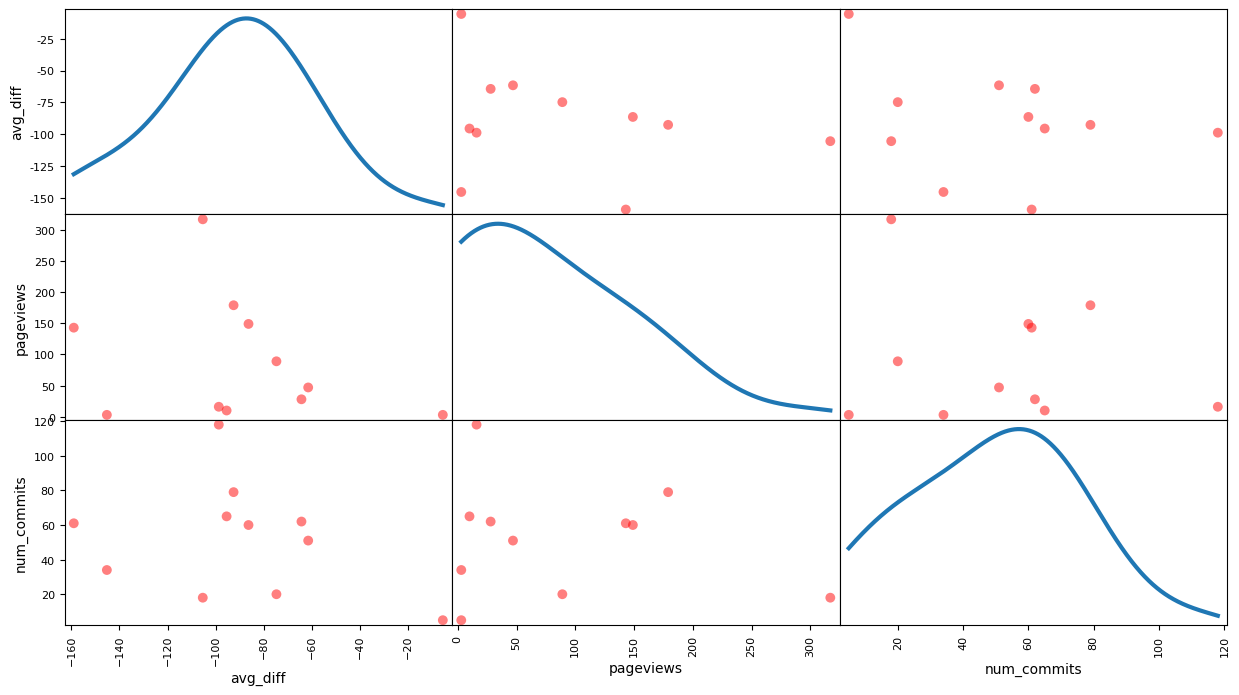

In [77]:
data = pivot[['avg_diff', 'pageviews', 'num_commits']]
scatter_matrix(data, figsize=(15, 8), diagonal='kde', s=200, color='r', density_kwds=dict(linewidth=3))

## “Can we say that if a user has a low number of pageviews then they likely have a low number of commits?” 
- answer: no

## “Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?”
- answer: no

## “Can we say that there are many users with a low number of commits and a few with a high number of commits”? 
- answer: yes (How much is this a lot?)

## “Can we say that there are many users with a small average difference and a few with a large average difference”? 
- answer: no (How much is this a lot?)

In [78]:
conn.close()